# Installation

The commands listed here should be written in a terminal, not in this notebook.

- Create and activate a new conda environment (if you don't have conda, you can install for example miniconda)
```
conda create -n bandit_tp python=3.8
conda activate bandit_tp
```
- Install dependencies
```
pip install jupyterlab
pip install scipy
pip install rlberry
```
- Launch jupyter
```
jupyter notebook
```
- Open this notebook

If everything was installed properly, the next cell should run without error.

In [1]:
import numpy as np
from rlberry.envs.bandits import Bandit, BernoulliBandit, NormalBandit
from rlberry.agents.bandits import (
    BanditWithSimplePolicy,
    IndexAgent,
    TSAgent,
    makeBoundedUCBIndex,
    makeSubgaussianUCBIndex,
    makeBetaPrior,
    makeGaussianPrior,
)
from rlberry.manager import AgentManager, read_writer_data, plot_writer_data
from rlberry.wrappers import WriterWrapper

c:\Users\Utilisateur\anaconda3\envs\rltutorials\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Bandits in rlberry

We will use the rlberry library, which contains classes used to model environements and agents in RL and bandits.
This first section is a simple example of how bandits are implemented in that library.

### Environments

The environment classes describe the effect of actions (pulling arms) in various states (only one state in bandits).

A stochastic bandit environment is basically a list of distributions: [Bandit](https://rlberry.readthedocs.io/en/latest/generated/rlberry.envs.bandits.Bandit.html#rlberry.envs.bandits.Bandit)

The class [NormalBandit](https://rlberry.readthedocs.io/en/latest/generated/rlberry.envs.bandits.NormalBandit.html#rlberry.envs.bandits.NormalBandit) is an example of this where the laws of the arms are Normal.

In [2]:
env_ctor = NormalBandit  # constructor for the environment

### Agents

An Agent describes how the algorithm chooses the next arm to pull in a given environment. All agents we will use inherit from the class [BanditWithSimplePolicy](https://rlberry.readthedocs.io/en/latest/generated/rlberry.agents.bandits.BanditWithSimplePolicy.html#rlberry.agents.bandits.BanditWithSimplePolicy). rlberry is a library that can handle generic RL, not only bandits, and the role of the BanditWithSimplePolicy class is mostly to specialize the RL problem to the bandit setting.

An important class of bandit methods are the [IndexAgent](https://rlberry.readthedocs.io/en/latest/generated/rlberry.agents.bandits.IndexAgent.html#rlberry.agents.bandits.IndexAgent): these algorithms compute an index for each arm, and pull the arm with highest index. UCB is an index agents.


In [3]:
class GaussianTSAgent(TSAgent):
    """Thompson sampling for Gaussian bandit"""
    
    name = "Gaussian TS Agent"

    def __init__(self, env, sigma=1.0, **kwargs):
        prior, _ = makeGaussianPrior(sigma)
        TSAgent.__init__(self, env, prior, **kwargs)
        # augment the environment with logging functionality
        self.env = WriterWrapper(self.env, self.writer, write_scalar="action")


class GaussianUCBAgent(IndexAgent):
    """UCB agent for Gaussian bandits"""

    name = "Gaussian UCB Agent"

    def __init__(self, env, sigma=1.0, **kwargs):
        index, _ = makeSubgaussianUCBIndex(sigma)  # the index is defined here
        IndexAgent.__init__(self, env, index, **kwargs)
        self.env = WriterWrapper(self.env, self.writer, write_scalar="action")

### AgentManager

rlberry contains various utilities to run multiple experiments in parallel, store all results, optimize the hyperparameters of the algorithms (not used in this notebook), etc.

An [AgentManager](https://rlberry.readthedocs.io/en/latest/generated/rlberry.manager.AgentManager.html#rlberry.manager.AgentManager) is a class to train, optimize hyperparameters, evaluate and gather statistics about an agent. We give the agent and environement to the AgentManager, as well as information like the number of steps of each experiment and the number of Monte-Carlo repetitions.

In [4]:
# Parameters of the problem
means = np.array([0.3, 0.5])  # means of the arms
sigma = 1.0  # standard deviation of the arm rewards
A = len(means)  # number of arms
T = 1000  # Horizon
M = 10  # number of MC simulations in experiments

In [5]:
# Construction of the experiment

env_kwargs = {"means": means, "stds": sigma * np.ones(A)} # parameters passed to the environment constructor

agents = [
    AgentManager(  # an AgentManager is used to repeatedly fit and evaluate an agent on an environment
        Agent,
        (env_ctor, env_kwargs),
        fit_budget=T,
        n_fit=M,
    )
    for Agent in [GaussianUCBAgent, GaussianTSAgent]
]

In [6]:
# Agent training

for agent in agents:
    agent.fit()  # 'fit' will run the agent n_fit times on the environment and store results

[INFO] Running AgentManager fit() for Gaussian UCB Agent with n_fit = 10 and max_workers = None. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not 

### Results and plots

The action taken by the various agents at every step of every experiment are recorded. Based on this, we can compute and plot the regret.

In [7]:
# Compute the regret
def compute_regret(actions, means):
    return np.cumsum(np.max(means) - means[actions.astype(int)])

c:\Users\Utilisateur\anaconda3\envs\rltutorials\lib\site-packages\rlberry\manager\evaluation.py:386: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(**lineplot_kwargs)


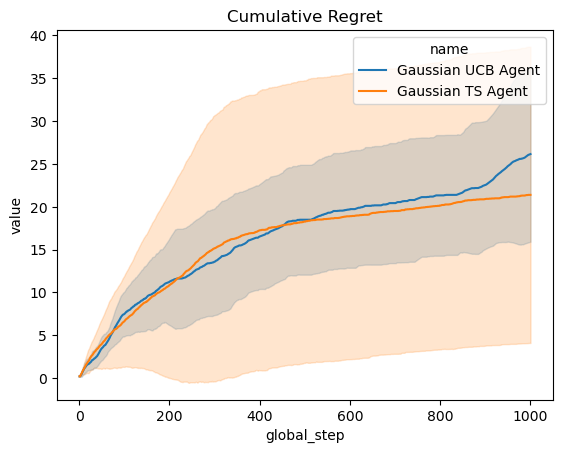

In [8]:
# We can get a dataframe with the results of the runs like this. You can use that object to inspect the data if you wish.
data = read_writer_data(agents, tag="action")

# plot the regret. This function plots the result of preprocess_func, applied to the action of the algorithm.
# The shaded area represents a standard deviation.
output = plot_writer_data(
    agents,
    tag="action",
    preprocess_func=lambda actions : compute_regret(actions, means),
    title="Cumulative Regret",
)

# Failure of Follow-The-Leader

The Follow-The-Leader algorithm (FTL) for bandits pulls the arm with highest empirical mean. That is, it pulls
$$
a_t = \arg\max_a \hat{\mu}_{t,a}
$$
where $\hat{\mu}_{t,a} = \frac{1}{N_{t,a}}\sum_{s=1}^{t-1} r_s \mathbb{I}\{a_s = a\}$.

### Questions
- 1) What is in general the dependence in the horizon $T$ of the regret of FTL? 

TODO: answer by writing in this cell

- 2) Complete the code of the FTL agent in the cell below

In [9]:
# FTL index

def makeFTLIndex():
    """
    Follow-The-Leader index

    Return
    ------
    Callable
        FTL index.

    Dict
        Extra parameters for the BanditTracker object.
        By default the tracker stores the number of pulls and the
        empirical average reward for each arm. If you want it to store
        all rewards for instance, return {'store_rewards': True}.

    """

    def index(tr):
        # tr is a BanditTracker object, which records information about the bandit problem
        # and past interactions between the agent and the environment.
        # In particular, tr.mu_hat(arm) gives the empirical mean of that arm.
        """
        Return an array with the index of each arm
        """
        return np.array([tr.mu_hat(arm) for arm in tr.arms])
    return index, {}


class FTLAgent(IndexAgent):
    """FTL agent for bandits"""

    name = "FTL Agent"

    def __init__(self, env, **kwargs):
        index, _ = makeFTLIndex()
        IndexAgent.__init__(self, env, index, **kwargs)
        self.env = WriterWrapper(self.env, self.writer, write_scalar="action")

- 3. Plot the regret of TS, UCB and FTL on a Gaussian bandit with 3 arms with means 0.3, 0.5 and 0.25, all with variance 1. Use a horizon $T=2000$ and $30$ Monte-Carlo repetitions.

In [11]:
# Parameters of the problem
means = np.array([0.3, 0.5,0.25])  # means of the arms
sigma = 1.0  # standard deviation of the arm rewards
A = len(means)  # number of arms
T = 2000  # Horizon
M = 30  # number of MC simulations in experiments
env_kwargs = {"means": means, "stds": sigma * np.ones(A)} # parameters passed to the environment constructor

agents = [
    AgentManager(  # an AgentManager is used to repeatedly fit and evaluate an agent on an environment
        Agent,
        (env_ctor, env_kwargs),
        fit_budget=T,
        n_fit=M,
    )
    for Agent in [GaussianUCBAgent, GaussianTSAgent, FTLAgent]
]

In [12]:

def plotAgents(agents):
    output = plot_writer_data(
    agents,
    tag="action",
    preprocess_func=lambda actions : compute_regret(actions, means),
    title="Cumulative Regret",
    )

def trainAgent(agents):
    for agent in agents : 
        agent.fit()
    return agents


[INFO] Running AgentManager fit() for Gaussian UCB Agent with n_fit = 30 and max_workers = None. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not 

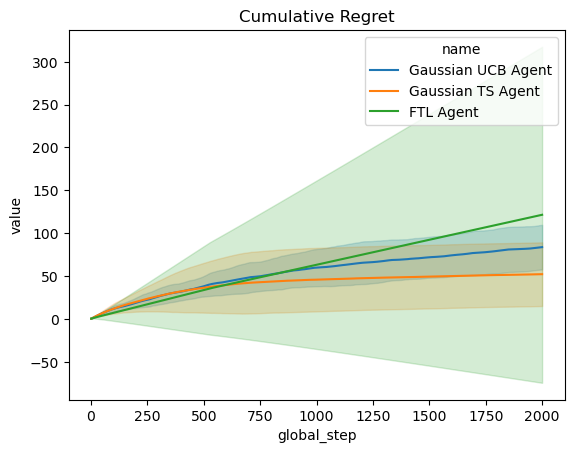

In [13]:
trainAgent(agents=agents)
plotAgents(agents)

- 4) Comment on the regrets of FTL, UCB and TS.

FTL : linéaire
Les autres UCB et TS sont meilleurs que linéires, ce que l'on cherche c'est dans l'idéal un regret qui finisse par converger vers une constante (et non pas l'infini comme FTL).
UCB et TS ont un regret plus faible que FTL.

# Linear Bandits

We consider the linear bandit problem, in which at time $t$, each arm $a$ is associated to a vector $x_{t,a} \in \mathbb{R}^d$ where $d \ll K$: the dimension of the features is lower than the number of arms. The reward observed by pulling $a_t$ is given by
$$
r_t = x_{t,a_t}^\top \theta + \varepsilon_t
$$
where $\theta \in \mathbb{R}^d$ is an unknown parameter vector and $\varepsilon_t$ is a mean zero Gaussian noise.

We saw in the lecture that this setting can be used to model a recommendation task in which we have access to *context* about the actions. The algorithms seen in class to minimize the regret in this setting are able to handle the case of $x_{t,a}$ changing with time, but we will now restrict our attention to a simpler model: each arm $a$ is associated with a vector $x_a \in \mathbb{R}^d$, which does not change with time (and which is known to the algorithm). Hence if arm $a$ is pulled at time $t$, the reward is $r_t = x_a^\top \theta + \varepsilon_t$.
We will suppose that $\varepsilon_t$ is Gaussian.

### Lin-UCB

The Lin-UCB algorithm maintains an estimate $\hat{\theta}_t$ for the unknown parameter $\theta$. It also computes a confidence region around that estimate. Like all UCB variants, it then pulls the arm with maximal possible value in the confidence region.

Lin-UCB maintains the following quantities:
$$
A_t = I_d + \sum_{s=1}^{t-1} x_{a_s}x_{a_s}^\top \\
b_t = \sum_{s=1}^{t-1} r_s x_{a_s} \\
\hat{\theta}_t = A_t^{-1} b_t
$$
Given that estimate $\hat{\theta}_t$, Lin-UCB samples
$$
a_t = \arg\max_a \hat{\theta}_{t,a}^\top x_a + \sigma \beta(t) \sqrt{x_a^\top A_t^{-1} x_a}
$$
where $\sigma^2$ is the variance of the Gaussian noise and where we can take $\beta(t) = \sqrt{2 \log(1 + (t+1)\log^2(t+1))}$.

Note: $A_{t+1}^{-1}$ can be computed online based on $A_t^{-1}$ and $x_{a_t}$ without inverting a matrix, by using the Sherman-Morrison formula. Please make sure that your implementation uses this formula.

In [14]:
# We define an environment for linear bandits with Gaussian noise

class LinearNormalBandit(NormalBandit):
    """
    Class for Linear Normal Bandits with constant set of arms

    Parameters
    ----------
    theta: array-like of size d, default=np.array([0, 1])
        unknown parameter of the bandit.
    
    arm_vects: array-like of size n_arms*d, default=np.array([[1, 0], [0, 1]])
        the mean of arm k is arm_vect[k].dot(theta)

    stds: array-like of size n_arms or None, default=None
        stds of the law of each of the arms. If None, use array with
        all ones.

    """

    def __init__(
        self,
        theta=np.array([0, 1]),
        arm_vects=np.array([[1, 0], [0, 1]]),
        stds=None,
    ):
        self.arm_vects = arm_vects
        self.d = len(arm_vects[0])
        self.theta = theta
        self.means = arm_vects.dot(theta)
        laws = self.make_laws(means, stds)  # defined in the NormalBandit class
        Bandit.__init__(self, laws=laws)

- 5) Complete the code of Lin-UCB in the cell below.

The variable `Ainv` is used to store the current value of $A_t^{-1}$. `b` is used to store $b_t$. The class below contains two getter methods `get_Ainv` and `get_b`, as well as a setter `set_Ainv_b`. These functions interract with the tracker to store and retrieve information.

Your task is to implement the index of Lin-UCB in the function `index_function`, to update `Ainv` and `b` after a reward is observed, and to implement the main step of the algorithm (get the index of each arm and pull the argmax).

In [18]:
# LinUCB. Note: we do not use the class IndexAgent because we want to store more information in the tracker than what
# is used in that class.

class LinUCBAgent(BanditWithSimplePolicy):
    """LinUCB agent for Linear Gaussian bandits"""

    name = "LinUCB Agent"

    def __init__(self, env, sigma=1.0, **kwargs):
        BanditWithSimplePolicy.__init__(self, env, **kwargs)
        self.arm_vects = self.env.arm_vects
        self.sigma = sigma
        self.d = self.env.d
        self.set_Ainv_b(np.identity(self.d), np.zeros(self.d))  # initialize Ainv and b to the identity and zero
        self.env = WriterWrapper(self.env, self.writer, write_scalar="action")

    def get_Ainv(self):  # get the stored value for Ainv, inverse of the design matrix
        Ainv = np.zeros((self.d, self.d))
        for dim in range(self.d):
            for dim2 in range(self.d):
                Ainv[dim, dim2] = self.tracker.read_last_tag_value("Ainv", str(dim) + "_" + str(dim2))
        return Ainv
    def beta(t):
        return np.sqrt(2*np.log(1+(t+1)*np.log(t+1)**2))

    def get_b(self):  # get the stored value for b
        return [self.tracker.read_last_tag_value("b", dim) for dim in range(self.d)]
    
    def set_Ainv_b(self, Ainv, b):  # store new values for Ainv and b
        for dim in range(self.d):
            tag_scalar_dict = { "b": b[dim] }
            self.tracker.add_scalars(dim, tag_scalar_dict)
            for dim2 in range(self.d):
                tag_scalar_dict = { "Ainv": Ainv[dim, dim2], }
                self.tracker.add_scalars(str(dim) + "_" + str(dim2), tag_scalar_dict)
    
    def index_function(self, tr, **kwargs):
        """
        Compute the LinUCB index for each arm, based on the stored values Ainv and b
        """
        return np.array([np.argmax(tr.theta.T@self.arm_vects)+self.sigma*self.beta(tr.t)*np.sqrt(self.arm_vects[i].T@self.get_Ainv(self)@self.arm_vects[i]) for i in range(tr.arms)])
    
    def update_tracker(self, action, reward):
        self.tracker.update(action, reward)  # do not change this line
        """
        Retrieve the current values of Ainv and b, and update them using the new 'action' and 'reward'.
        To store the new values, use the set_Ainv_b function.
        """
        Ainv_old = self.get_Ainv()
        Ainv =  Ainv_old - (Ainv_old@self.arm_vects[action].T@self.arm_vects[action]@Ainv_old)/(1+self.arm_vects[action]@Ainv_old@self.arm_vects[action].T)
        b_old = self.get_b()
        b=b_old+reward@self.arm_vects[action]
        self.set_Ainv_b(Ainv=Ainv,b=b)
    
    def fit(self, budget=None, **kwargs):
        """
        Train the bandit using the provided environment.

        Parameters
        ----------
        budget: int
            Total number of iterations, also called horizon.
        """
        horizon = budget
        total_reward = 0.0
        indices = np.inf * np.ones(self.n_arms)

        for ep in range(horizon):
            # Warmup: play every arm one before starting computing indices
            if ep < self.n_arms:
                action = ep
            else:
                """
                Compute index for each arm and play the highest one
                """
                action = np.argmax(self.index_function(self.tracker))

            _, reward, _, _ = self.env.step(action)

            # Feed the played action and the resulting reward to the tracker
            self.update_tracker(action, reward)

            total_reward += reward

        # Best action in hinsight is the one with highest index
        self.optimal_action = np.argmax(indices)

        info = {"episode_reward": total_reward}
        return info

- 6) Plot the regret of LinUCB, TS and UCB on a linear Gaussian bandit problem with 2 arms and the following parameters:
$$
\theta = (0, 0.3), \  x_1 = (1, 0), \ x_2 = (0, 1), \sigma = 1
\\
T = 1000
$$
Use 30 repetitions for each experiment.

In [19]:
# Parameters of the problem
sigma = 1.0  # standard deviation of the arm rewards
A = len(means)  # number of arms
T = 1000  # Horizon
M = 30  # number of MC simulations in experiments
sigma=1

env_kwargs = {"theta": np.array([0, 0.3]), "arm_vects": np.array([[1, 0], [0, 1]])} # parameters passed to the environment constructor


env_ctor = LinearNormalBandit

agents = [
    AgentManager(  # an AgentManager is used to repeatedly fit and evaluate an agent on an environment
        Agent,
        (env_ctor, env_kwargs),
        fit_budget=T,
        n_fit=M,
    )
    for Agent in [GaussianUCBAgent, GaussianTSAgent, LinUCBAgent]
]

In [21]:
import warnings
warnings.filterwarnings("ignore")

In [20]:

trainAgent(agents=agents)
plotAgents(agents)

[INFO] Running AgentManager fit() for Gaussian UCB Agent with n_fit = 30 and max_workers = None. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not possible to reseed environment. 
[WARNING] [Agent] Not 

ValueError: matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

- 7) Compare the three algorithms on that experiement. Does the knowledge of the linear structure help LinUCB? Explain.

TODO: answer here

- 8) Plot the regret of LinUCB, TS and UCB on a linear Gaussian bandit problem with 10 arms and the following parameters:
$$
\theta = (0, 0.3), \  x_1 = (1, 0), \ x_2 = (0, 1), \ x_3 = (0.3, 0.2), \ x_{i} = (0.6, 0.6) \text{ for } i\ge 4, \ \sigma = 1
\\
T = 1000
$$
Use 30 repetitions for each experiment.



- 9) Compare the three algorithms on that experiement. Does the knowledge of the linear structure help LinUCB? Explain.

TODO: answer here

### Linear Thompson Sampling

- 10) Implement linear Thompson Sampling and compare it to LinUCB on several experiments. You can start from a copy of the code of LinUCB and modify the index definition.

That question is intentionally open: a thorough and well presented experimental comparison will give bonus points.